<a href="https://colab.research.google.com/github/tsakailab/sandbox/blob/master/pytorch_nuc_prox_backward_cuda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_cached())
    torch.cuda.empty_cache()

Tesla P4
0
0


# Nuclear Loss backward with prox (singular value thresholding)

In [0]:
soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

class NuclearLossFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, lw):
        u, s, v = torch.svd(input)
        ctx.save_for_backward(input, lw, u, s, v)
        return torch.sum(s*lw)

    @staticmethod
    def backward(ctx, grad_output):
        input, lw, u, s, v = ctx.saved_tensors
        grad_input = grad_output.clone()
        svt_input = torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,lw))), torch.transpose(v, -2, -1))
        return (input - svt_input) * grad_input, s * grad_input


class NuclearLoss(torch.nn.Module):
    def __init__(self, lw=torch.tensor(1.0, device=device)):
        super(NuclearLoss, self).__init__()
        self.fn = NuclearLossFunc.apply
        self.lw = torch.nn.Parameter(lw, requires_grad=lw.requires_grad)

    def forward(self, input):
        return self.fn(input, self.lw)


# Demonstration 1: observe gradients
### Auto differentiation vs. proximal operation

In [0]:
torch.cuda.empty_cache()
#D = torch.autograd.Variable(torch.randn(32,40000,60, device=device), requires_grad=True)
D = torch.autograd.Variable(torch.randn(2,3,5, device=device), requires_grad=True)
Dr = torch.autograd.Variable(D, requires_grad=True)

In [4]:
#ll = 0.5 * torch.ones(min(3,5), device=device)
ll = torch.tensor(0.9, device=device)
print('lambda = \n', ll)
#lw = ll.clone()
lw = torch.autograd.Variable(ll, requires_grad=True)
lwr = torch.autograd.Variable(ll, requires_grad=True)

# l1 norm and its backprop
from time import time
t0 = time()

print("Singular values = \n", torch.svd(D)[1])
nucloss = NuclearLoss(lw=lw)
loss = nucloss.forward(D)
loss.backward(retain_graph=True)
print('done in %.2fms' % ((time() - t0)*1000))
print('nuclear loss = ', loss.item())

lw_sum_sv = torch.sum(torch.svd(Dr)[1]*lwr)
lw_sum_sv.backward(retain_graph=True)
print('sum of singular values = ', lw_sum_sv.item())

lambda = 
 tensor(0.9000, device='cuda:0')
Singular values = 
 tensor([[4.1567, 2.2873, 0.9343],
        [1.8618, 1.6319, 0.8835]], device='cuda:0', grad_fn=<SvdBackward>)
done in 29.69ms
nuclear loss =  10.580000877380371
sum of singular values =  10.580000877380371


### Prox of L1 norm provides gradients that cut down (sparsify) the data entries by the weight lambda while the autorgad cannot.  Imagine the gradient descent (D$-$D.grad).


In [5]:
print('data = \n', D)
print('\n Gradient of nuclear loss w.r.t. data by prox = \n', D.grad)
print('\n Gradient of nuclear loss w.r.t. lambda = \n', nucloss.lw.grad)
print('\n data = \n', Dr)
print('\n Gradient of sum of singular values w.r.t. data by autograd = \n', Dr.grad)
print('\n Gradient of  sum of singular values w.r.t. lambda = \n', lwr.grad)

data = 
 tensor([[[ 0.4597,  2.6543, -0.3760, -2.6877,  0.3359],
         [ 1.0368,  1.2488,  0.8116, -0.6227, -0.7786],
         [ 1.2595, -1.2605,  0.7054,  0.0130, -0.8292]],

        [[-0.5750, -0.0742, -0.2057, -0.2931,  1.1085],
         [-0.4699, -0.8836,  0.0231,  0.5880,  0.7729],
         [ 0.6618, -1.1082, -0.2748, -1.2158,  0.2281]]], device='cuda:0',
       requires_grad=True)

 Gradient of nuclear loss w.r.t. data by prox = 
 tensor([[[ 0.1343,  0.4073, -0.1847, -0.7558,  0.1441],
         [ 0.3162,  0.5459,  0.4681,  0.1578, -0.4098],
         [ 0.5640, -0.5660,  0.1616, -0.2912, -0.2462]],

        [[-0.3841,  0.1959, -0.1562, -0.3093,  0.6980],
         [-0.2111, -0.6371,  0.0626,  0.4933,  0.3160],
         [ 0.3578, -0.5563, -0.1278, -0.5932,  0.0642]]], device='cuda:0')

 Gradient of nuclear loss w.r.t. lambda = 
 tensor(11.7556, device='cuda:0')

 data = 
 tensor([[[ 0.4597,  2.6543, -0.3760, -2.6877,  0.3359],
         [ 1.0368,  1.2488,  0.8116, -0.6227, -0.7786]

# Demonstration 2: minimize nuclear loss $$\mbox{Minimize}_X\|X-D\|_*$$
###Note that NuclearLoss is not differentiable at low-rank matrices in a matrix space, so augograd cannot find the minimizer.

In [6]:
D = torch.randn(2,3,5, device=device)
print('D = \n', D)

D = 
 tensor([[[-3.0307, -0.5427,  0.6131,  1.3066, -0.8404],
         [ 1.4701, -1.2852, -2.6925,  0.7141, -0.4263],
         [ 0.5010, -0.6573,  0.4081,  0.0763, -0.8680]],

        [[ 0.9476, -0.1991,  0.2063,  1.0195, -1.8145],
         [ 1.5864,  0.1531, -0.3000,  1.6152,  1.7262],
         [ 0.3771,  0.5302, -2.4082, -0.6667,  0.8107]]], device='cuda:0')


lambda = 
 0.5
[  1/30]: loss = 10.2600,  
[  2/30]: loss = 8.7600,  
[  3/30]: loss = 7.2600,  
[  4/30]: loss = 5.7600,  
[  5/30]: loss = 4.6387,  
[  6/30]: loss = 3.8887,  
[  7/30]: loss = 3.1387,  
[  8/30]: loss = 2.3887,  
[  9/30]: loss = 1.7672,  
[ 10/30]: loss = 1.2672,  
[ 11/30]: loss = 0.7672,  
[ 12/30]: loss = 0.2672,  
[ 13/30]: loss = 0.0040,  
[ 14/30]: loss = 0.0000,  
[ 15/30]: loss = 0.0000,  
[ 16/30]: loss = 0.0000,  
[ 17/30]: loss = 0.0000,  
[ 18/30]: loss = 0.0000,  
[ 19/30]: loss = 0.0000,  
[ 20/30]: loss = 0.0000,  
[ 21/30]: loss = 0.0000,  
[ 22/30]: loss = 0.0000,  
[ 23/30]: loss = 0.0000,  
[ 24/30]: loss = 0.0000,  
[ 25/30]: loss = 0.0000,  
[ 26/30]: loss = 0.0000,  
[ 27/30]: loss = 0.0000,  
[ 28/30]: loss = 0.0000,  
[ 29/30]: loss = 0.0000,  
[ 30/30]: loss = 0.0000,  
D = 
 tensor([[[-3.0307, -0.5427,  0.6131,  1.3066, -0.8404],
         [ 1.4701, -1.2852, -2.6925,  0.7141, -0.4263],
         [ 0.5010, -0.6573,  0.4081,  0.0763, -0.8680]],

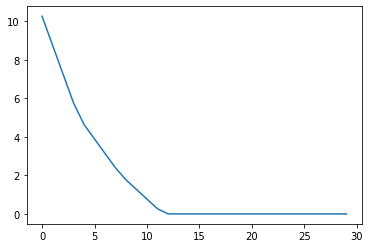

In [7]:
#ll = 0.5 * torch.ones(3,5, device=device)
ll = 0.5
print('lambda = \n', ll)

# Using L1Loss with prox
nucloss = NuclearLoss(lw=torch.tensor(ll))
X = torch.autograd.Variable(torch.randn(D.shape, device=device), requires_grad=True)
optimizer = torch.optim.SGD([X], lr = 1e0)

t0 = time()
num_iter = 30
display_step = 1
history_loss_prox = []
for iter in range(num_iter):
    loss = nucloss(X - D)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    history_loss_prox.append(loss.item())

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, loss.item()))

print('D = \n', D)
print('X = \n', X)
import matplotlib.pyplot as plt
plt.plot(history_loss_prox)

lambda = 
 0.5
[  1/30]: loss = 10.8450,  
[  2/30]: loss = 9.3450,  
[  3/30]: loss = 7.8450,  
[  4/30]: loss = 6.3450,  
[  5/30]: loss = 4.9625,  
[  6/30]: loss = 4.1064,  
[  7/30]: loss = 2.9625,  
[  8/30]: loss = 2.5004,  
[  9/30]: loss = 1.4625,  
[ 10/30]: loss = 1.0142,  
[ 11/30]: loss = 0.5947,  
[ 12/30]: loss = 0.9053,  
[ 13/30]: loss = 0.5947,  
[ 14/30]: loss = 0.9053,  
[ 15/30]: loss = 0.5947,  
[ 16/30]: loss = 0.9053,  
[ 17/30]: loss = 0.5947,  
[ 18/30]: loss = 0.9053,  
[ 19/30]: loss = 0.5947,  
[ 20/30]: loss = 0.9053,  
[ 21/30]: loss = 0.5947,  
[ 22/30]: loss = 0.9053,  
[ 23/30]: loss = 0.5947,  
[ 24/30]: loss = 0.9053,  
[ 25/30]: loss = 0.5947,  
[ 26/30]: loss = 0.9053,  
[ 27/30]: loss = 0.5947,  
[ 28/30]: loss = 0.9053,  
[ 29/30]: loss = 0.5947,  
[ 30/30]: loss = 0.9053,  
D = 
 tensor([[[-3.0307, -0.5427,  0.6131,  1.3066, -0.8404],
         [ 1.4701, -1.2852, -2.6925,  0.7141, -0.4263],
         [ 0.5010, -0.6573,  0.4081,  0.0763, -0.8680]],

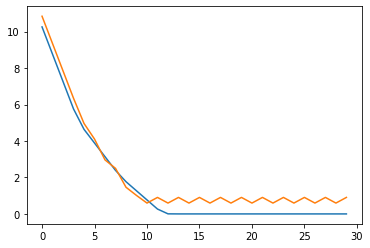

In [8]:
#ll = 0.5 * torch.ones(3,5, device=device)
ll = 0.5
print('lambda = \n', ll)

# Using sum of abs with autogradient
nucloss = lambda x: torch.sum(torch.svd(x)[1]*ll)
X = torch.autograd.Variable(torch.randn(D.shape, device=device), requires_grad=True)
optimizer = torch.optim.SGD([X], lr = 1e0)

t0 = time()
num_iter = 30
display_step = 1
history_loss = []
for iter in range(num_iter):
    loss = nucloss(X - D)
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    history_loss.append(loss.item())

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, loss.item()))

print('D = \n', D)
print('X = \n', X)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history_loss_prox)
plt.plot(history_loss)